In [3]:
!pip install ampligraph==2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.9 MB/s

In [1]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf

In [2]:
tf.test.is_gpu_available()

True

In [3]:
import requests
url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/football_graph.csv'
open('football_results.csv', 'wb').write(requests.get(url).content)

3033782

In [4]:
df = pd.read_csv("football_results.csv").sort_values("date")

In [5]:
df = df.dropna()

In [6]:
# Entities naming
df["match_id"] = df.index.values.astype(str)
df["match_id"] =  "Match" + df.match_id
df["city_id"] = "City" + df.city.str.title().str.replace(" ", "")
df["country_id"] = "Country" + df.country.str.title().str.replace(" ", "")
df["home_team_id"] = "Team" + df.home_team.str.title().str.replace(" ", "")
df["away_team_id"] = "Team" + df.away_team.str.title().str.replace(" ", "")
df["tournament_id"] = "Tournament" + df.tournament.str.title().str.replace(" ", "")
df["neutral"] = df.neutral.astype(str)

In [7]:
triples = []
for _, row in df.iterrows():
    # Home and away information
    home_team = (row["home_team_id"], "isHomeTeamIn", row["match_id"])
    away_team = (row["away_team_id"], "isAwayTeamIn", row["match_id"])

    # Match results
    if row["home_score"] > row["away_score"]:
        score_home = (row["home_team_id"], "winnerOf", row["match_id"])
        score_away = (row["away_team_id"], "loserOf", row["match_id"])
    elif row["home_score"] < row["away_score"]:
        score_away = (row["away_team_id"], "winnerOf", row["match_id"])
        score_home = (row["home_team_id"], "loserOf", row["match_id"])
    else:
        score_home = (row["home_team_id"], "draws", row["match_id"])
        score_away = (row["away_team_id"], "draws", row["match_id"])
    home_score = (row["match_id"], "homeScores", np.clip(int(row["home_score"]), 0, 5))
    away_score = (row["match_id"], "awayScores", np.clip(int(row["away_score"]), 0, 5))

    # Match characteristics
    tournament = (row["match_id"], "inTournament", row["tournament_id"])
    city = (row["match_id"], "inCity", row["city_id"])
    country = (row["match_id"], "inCountry", row["country_id"])
    neutral = (row["match_id"], "isNeutral", row["neutral"])
    year = (row["match_id"], "atYear", row["date"][:4])

    triples.extend((home_team, away_team, score_home, score_away,
                    tournament, city, country, neutral, year, home_score, away_score))

In [8]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df[(triples_df.subject=="Match3129") | (triples_df.object=="Match3129")]

,subject,predicate,object
34419,TeamBrazil,isHomeTeamIn,Match3129
34420,TeamUruguay,isAwayTeamIn,Match3129
34421,TeamBrazil,loserOf,Match3129
34422,TeamUruguay,winnerOf,Match3129
34423,Match3129,inTournament,TournamentFifaWorldCup
34424,Match3129,inCity,CityRioDeJaneiro
34425,Match3129,inCountry,CountryBrazil
34426,Match3129,isNeutral,False
34427,Match3129,atYear,1950
34428,Match3129,homeScores,1


In [9]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=10000)

In [10]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (438481, 3)
Test set size:  (10000, 3)


In [11]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
model = ScoringBasedEmbeddingModel(k=100,
                                   eta=20,
                                   scoring_type='ComplEx',
                                   seed=0)

In [12]:
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

model.compile(loss=loss,
              optimizer=optimizer,
              entity_relation_regularizer=regularizer,
              entity_relation_initializer='glorot_uniform')

In [13]:
model.fit(X_train,
          batch_size=10000,
          epochs=200,
          verbose=True)

Epoch 1/200
45/45 [==============================] - 11s 253ms/step - loss: 30340.1387
Epoch 2/200
45/45 [==============================] - 3s 69ms/step - loss: 30339.9121
Epoch 3/200
45/45 [==============================] - 3s 69ms/step - loss: 30339.6387
Epoch 4/200
45/45 [==============================] - 3s 72ms/step - loss: 30339.2109
Epoch 5/200
45/45 [==============================] - 3s 70ms/step - loss: 30338.5020
Epoch 6/200
45/45 [==============================] - 3s 69ms/step - loss: 30337.3496
Epoch 7/200
45/45 [==============================] - 3s 71ms/step - loss: 30335.5840
Epoch 8/200
45/45 [==============================] - 3s 70ms/step - loss: 30332.9922
Epoch 9/200
45/45 [==============================] - 3s 70ms/step - loss: 30329.3535
Epoch 10/200
45/45 [==============================] - 3s 70ms/step - loss: 30324.4355
Epoch 11/200
45/45 [==============================] - 3s 69ms/step - loss: 30318.0508
Epoch 12/200
45/45 [==============================] - 3s 69ms

In [14]:
filter = {'test': np.concatenate([X_train, X_test])}

In [15]:
ranks = model.evaluate(X_test,
                       use_filter=filter,
                       corrupt_side='s,o',
                       verbose=True)

314/314 [==============================] - 173s 551ms/step


In [16]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.27
MR: 2290.89
Hits@10: 0.41
Hits@3: 0.31
Hits@1: 0.19


In [17]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

Cloning into 'incf.countryutils'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 132 (delta 20), reused 39 (delta 16), pack-reused 87
Receiving objects: 100% (132/132), 66.24 KiB | 569.00 KiB/s, done.
Resolving deltas: 100% (58/58), done.
Processing /content/incf.countryutils
  Preparing metadata (setup.py) ... done
  Created wheel for incf.countryutils: filename=incf.countryutils-1.2-py3-none-any.whl size=21400 sha256=0c8c797e50bc6153c87405d46716fa2a17a1548eb322a41020c58411dcda6086
  Stored in directory: /tmp/pip-ephem-wheel-cache-w2c7opw2/wheels/c9/1a/60/d7400cda03816dbfc1647ccbb66be83b3e42077058131932d1
Successfully built incf.countryutils


In [18]:
!pip install adjustText==0.8

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

In [20]:
id_to_name_map = {**dict(zip(df.home_team_id, df.home_team)), **dict(zip(df.away_team_id, df.away_team))}

In [22]:
teams = pd.concat((df.home_team_id, df.away_team_id)).unique()
team_embeddings = dict(zip(teams, model.get_embeddings(teams)))

In [23]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in team_embeddings.values()]))

In [24]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=6, n_init=100, max_iter=500, random_state=0)
clusters = find_clusters(teams, model, clustering_algorithm, mode='e')

In [25]:
def cn_to_ctn(country):
    try:
        return transformations.cn_to_ctn(id_to_name_map[country])
    except KeyError:
        return "unk"

In [26]:
plot_df = pd.DataFrame({"teams": teams,
                        "embedding1": embeddings_2d[:, 0],
                        "embedding2": embeddings_2d[:, 1],
                        "continent": pd.Series(teams).apply(cn_to_ctn),
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [27]:
top20teams = ["TeamBelgium", "TeamFrance", "TeamBrazil", "TeamEngland",
              "TeamUruguay", "TeamCroatia", "TeamPortugal", "TeamSpain",
              "TeamArgentina", "TeamColombia", "TeamMexico", "TeamSwitzerland",
              "TeamItaly", "TeamNetherlands", "TeamGermany", "TeamDenmark",
              "TeamChile", "TeamSweden", "TeamPoland", "TeamSenegal"]

def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df[plot_df.continent!="unk"], x="embedding1", y="embedding2", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if point["teams"] in top20teams or np.random.random() < 0.1:
            texts.append(plt.text(point['embedding1']+0.02, point['embedding2']+0.01, str(point["teams"])))
    adjust_text(texts)

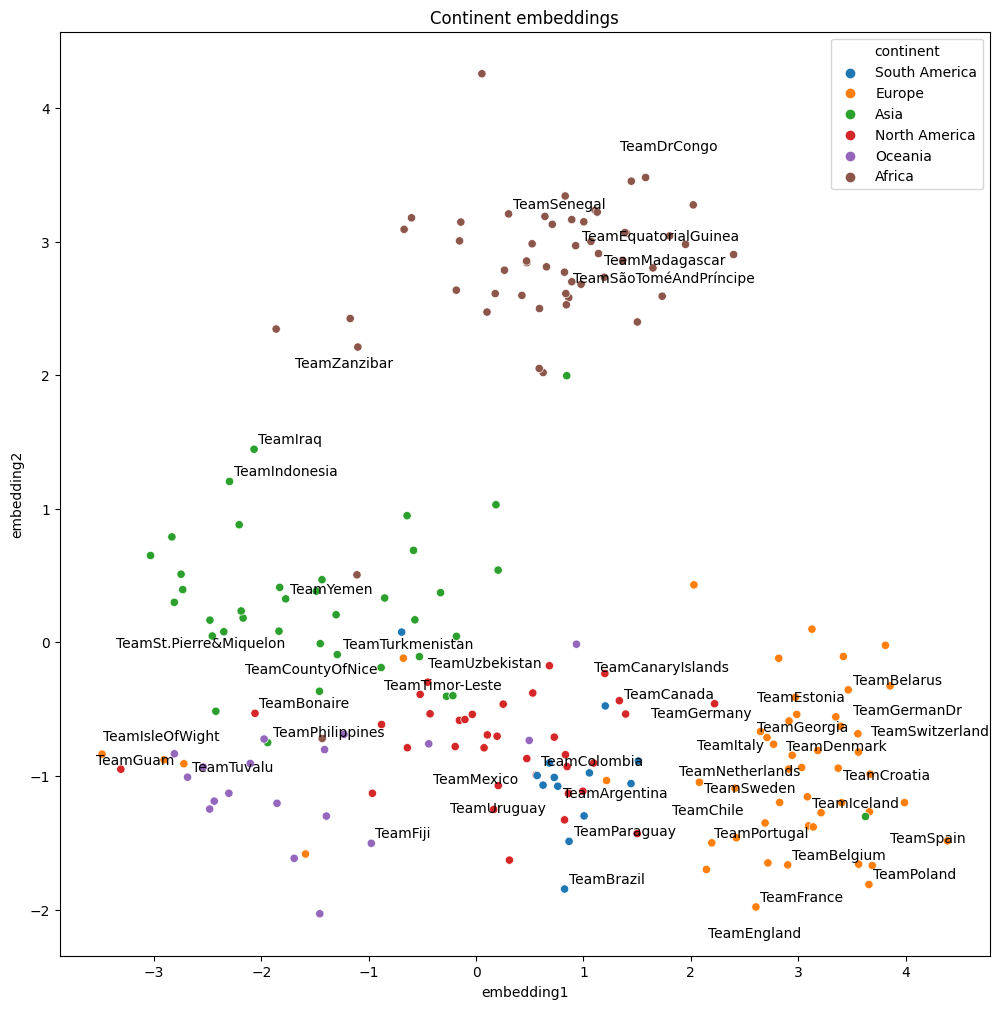

In [28]:
plot_clusters("continent")

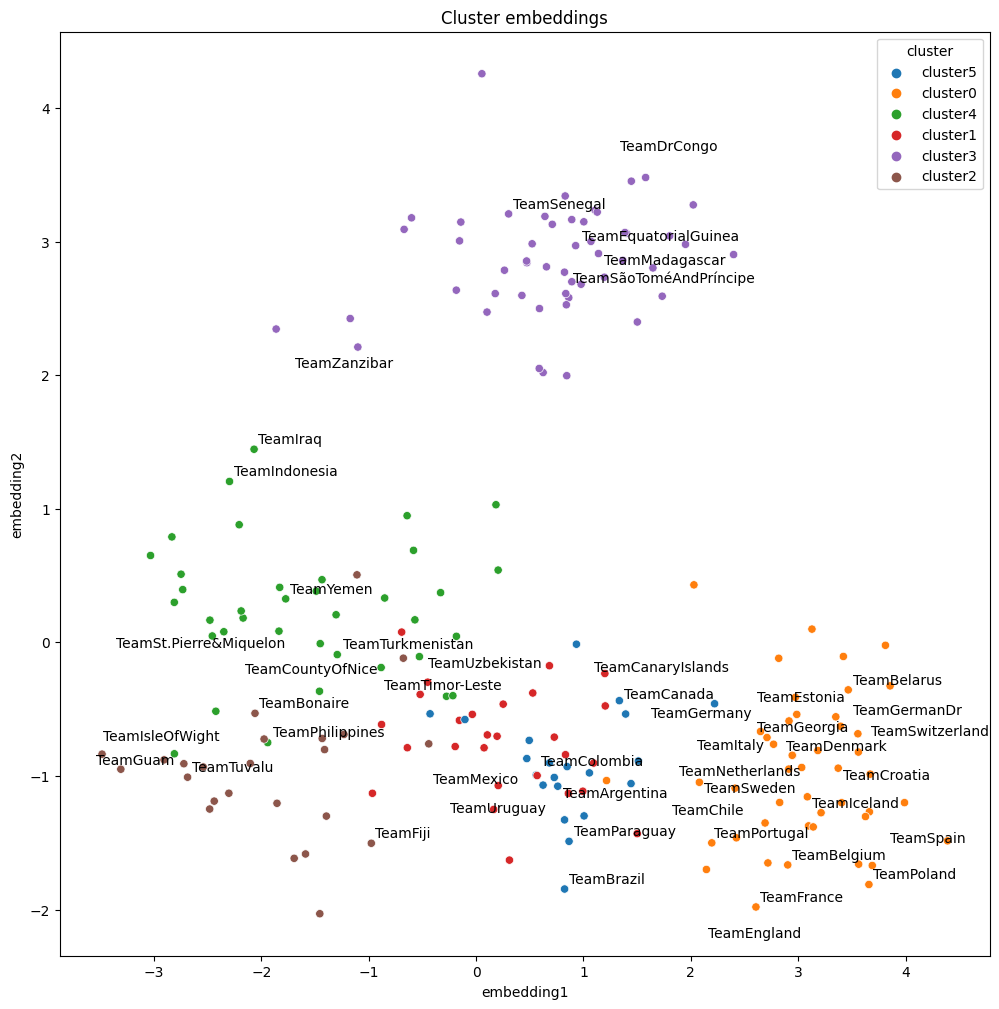

In [29]:
plot_clusters("cluster")

In [30]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.continent, plot_df.cluster)

0.47671604698504744